## 声明式编程（静态图）与命令式编程（动态图）

从深度学习模型构建方式上看，飞桨支持声明式编程（静态图/Declarative programming）和命令式编程（动态图/Imperative programming）两种方式。二者的区别是：
- 静态图采用先编译后执行的方式。用户需预先定义完整的网络结构，再对网络结构进行编译优化后，才能执行获得计算结果。
- 动态图采用解析式的执行方式。用户无需预先定义完整的网络结构，每执行一行代码就可以获得代码的输出结果。
- 动态图模式下构建的模型不能直接预测部署，需要转换为静态图模型后才能部署。

### 静态图

飞桨静态图核心架构分为Python前端和C++后端两个部分，用户通过Python语言使用飞桨，但训练和预测的执行后端均为C++程序，这使得飞桨兼具轻松的编程体验和极高的执行效率。

静态图的核心概念：
- Variable：表示网络中的数据
- Operator：表示网络中的操作（算子）
- Block：表示编程语言中的控制流结构，如条件结构（if-else）、循环结构（while）等
- Program：基于Protobuf的序列化能力提供模型保存、加载功能。Protobuf是Google推出的一个结构化数据的序列化框架，可将结构化数据序列化为二进制流，或从二进制流中反序列化出结构化数据。飞桨模型的保存、加载功能依托于Protobuf的序列化和反序列化能力
- Transpiler：可选的编译步骤，作用是将一个Program转换为另一个Program
- Intermediate Representation：在执行前期，用户定义的Program会转换为一个统一的中间表达
- Executor：用于快速调度 Operator ，完成网络训练/预测

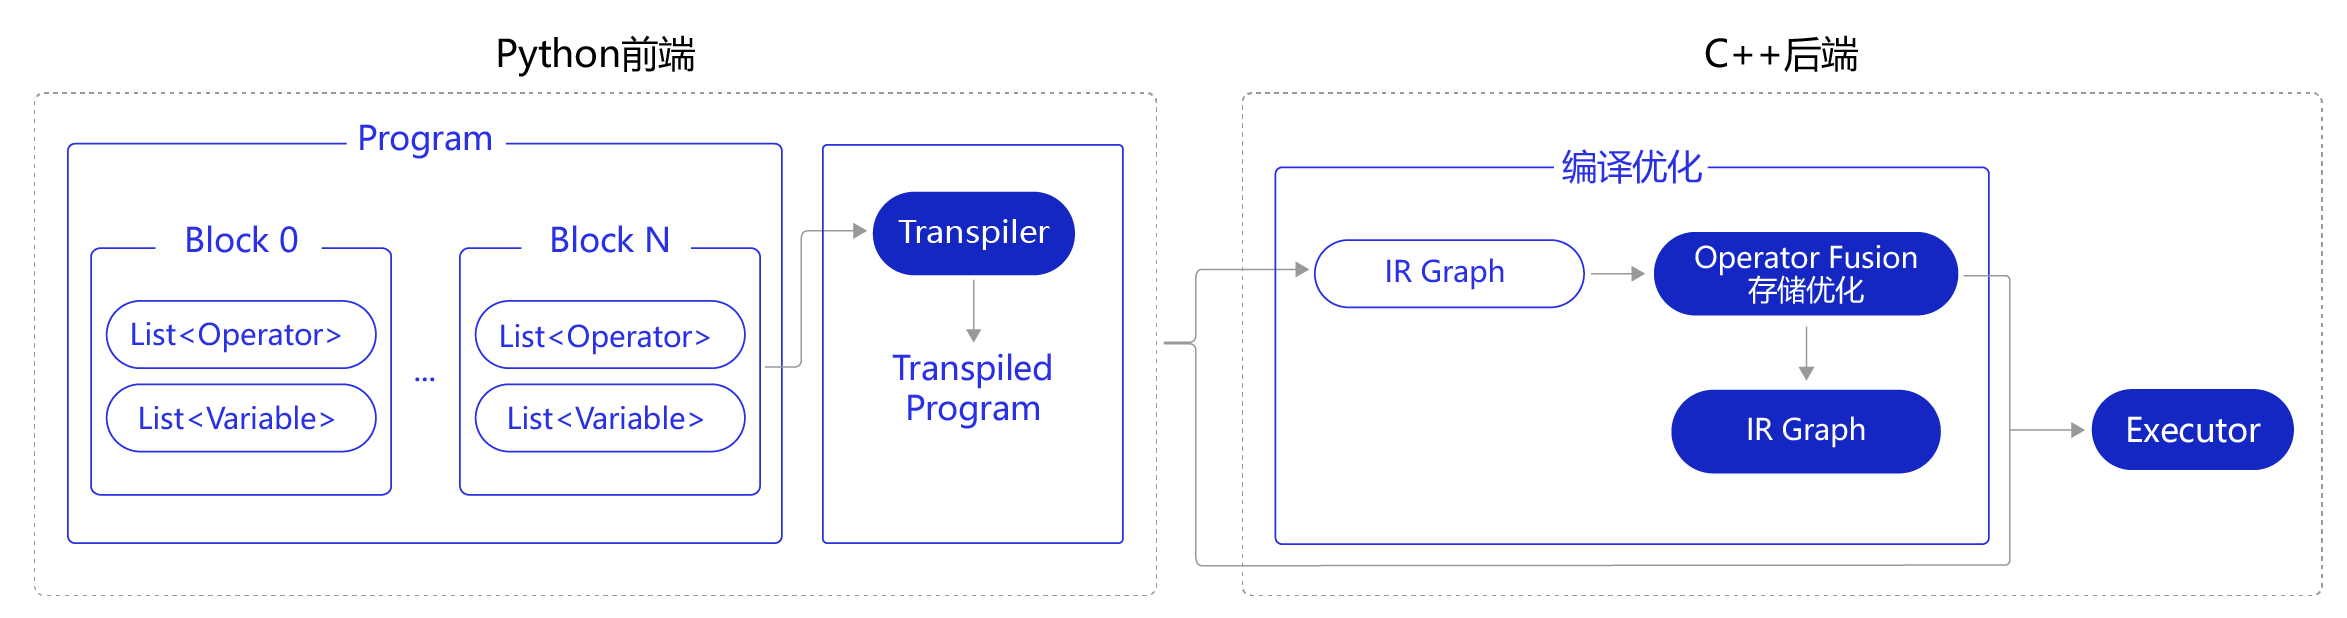

### 动态图

- 在动态图模式下，Operator 是即时执行的，即用户每调用一个飞桨API，API均会马上执行返回结果
- 在模型训练过程中，在运行前向 Operator 的同时，框架底层会自动记录对应的反向 Operator 所需的信息，即一边执行前向网络，另一边同时构建反向计算图。
- 在动态图模式下，执行器并不是先掌握完整的网络全图，再按照固定模式批量执行。而是根据Python的原生控制流代码，逐条执行前向计算过程和后向计算过程，其中后向计算的逻辑飞桨框架会在前向计算的时候自动化构建。

### 动态图与静态图的差异

动态图模式和静态图模式底层算子实现的方法是相同的，不同点在于：

- 代码组织方式不同
    - 在使用静态图实现算法训练时，需要使用很多代码完成预定义的过程，包括program声明，执行器Executor执行program等等。但是在动态图中，动态图的代码是实时解释执行的，训练过程也更加容易调试。
- 代码执行方式不同
    - 在静态图模式下，完整的网络结构在执行前是已知的，因此图优化分析的灵活性比较大，往往执行性能更佳，但调试难度大。
    - 在动态图模式下，完整的网络结构在执行前是未知的，因此图优化分析的灵活性比较低，执行性能往往不如静态图，但调试方便。

### 动转静的设计原理

动态图程序自动转成静态图训练和执行的功能，主要有两个应用场景：
- 因为动态图对组网中控制流的描述使用Python语言，所以静态图和动态图的模型格式不同。但部署工具使用的是静态图模型，所以动态图模型需要转成静态图才能顺利使用部署工具。
- 静态图模式是整图优化（拿到了全部的模型组网和训练信息），在部分场景下性能更好。

飞桨默认的编程模式是动态图模式，包括使用高层API编程和基础的API编程。如果想切换到静态图模式编程，可以在程序的开始执行enable_static()函数。如果程序已经使用动态图的模式编写了，想转成静态图模式训练或者保存模型用于部署，可以使用装饰器@to_static。